<a href="https://colab.research.google.com/github/ElMango29/Personal_Project_Code_29021728/blob/main/Personal_Project_Code_29021728.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

# Technical indicators

!pip install pandas_ta
import pandas_ta as pta

## !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz

## !tar -xzf ta-lib-0.4.0-src.tar.gz
## %cd ta-lib/
## !./configure --prefix=$HOME
## !make
## !make install

## !TA_LIBRARY_PATH=~/lib TA_INCLUDE_PATH=~/include pip install ta-lib
#import talib


plt.style.use("seaborn")
plt.rcParams["figure.figsize"] = [14, 8]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 115 kB 5.2 MB/s 
  Created wheel for pandas-ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218923 sha256=0c760b321f2b8e04e2cf3ebf9012dc1ec6a9210fc0182f6a4612cbb8f112a83e
  Stored in directory: /root/.cache/pip/wheels/0b/81/f0/cca85757840e4616a2c6b9fe12569d97d324c27cac60724c58
Successfully built pandas-ta


In [2]:
from sklearn.preprocessing import MinMaxScaler

import keras
from keras import optimizers
from keras.callbacks import History
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate, TimeDistributed

import tensorflow as tf

In [ ]:
!pip install ray filelock
!pip install bayesian-optimization
from bayes_opt import BayesianOptimization
from ray import tune
from ray.tune.search.bayesopt import BayesOptSearch

In [ ]:
# Upload the data file
from google.colab import files
files.upload()

In [5]:
# Read the data file (df)
df = pd.read_csv('GBPUSD1440.csv', 
                 names=["Date", "Time", "Open", "High", "Low", "Close", "Volume"], 
                 sep=' |\t', 
                 engine='python')

# View the data
df

,Date,Time,Open,High,Low,Close,Volume
0,"""2007-01-01",00:00,1.95805,1.96417,1.95765,1.96332,"146179"""
1,"""2007-01-02",00:00,1.96330,1.97418,1.96040,1.97295,"157568"""
2,"""2007-01-03",00:00,1.97301,1.97490,1.94814,1.95169,"147924"""
3,"""2007-01-04",00:00,1.95165,1.95296,1.93980,1.94258,"148462"""
4,"""2007-01-05",00:00,1.94251,1.94316,1.92633,1.92900,"142467"""
...,...,...,...,...,...,...,...
4916,"""2022-09-19",00:00,1.14336,1.14451,1.13549,1.14442,"90126"""
4917,"""2022-09-20",00:00,1.14443,1.14605,1.13570,1.13801,"151416"""
4918,"""2022-09-21",00:00,1.13802,1.13842,1.12350,1.12565,"194063"""
4919,"""2022-09-22",00:00,1.12566,1.13638,1.12113,1.12621,"225720"""


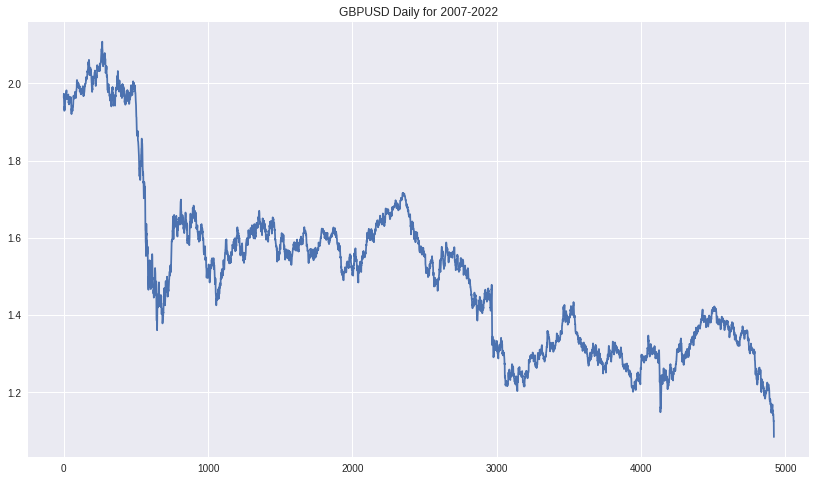

In [ ]:
# Plot the data for Adj Close
df["Close"].plot(title="GBPUSD Daily for 2007-2022");

In [6]:
# Adding indicators via adding columns to the data (df) table
df['RSI'] = pta.rsi(df.Close, length=15)
df['EMAF'] = pta.rsi(df.Close, length=20)
df['EMAM'] = pta.rsi(df.Close, length=100)
df['EMAS'] = pta.rsi(df.Close, length=150)

# The target, aka expected output.
# Can be calculated in 3 ways.
# First: Difference in current open and future close price.
#df['Target'] = df['Close'] - df.Open
#df['Target'] = df['Target'].shift(-1)


# 2: Calculating whether the price went up or down between closing days.
# Could be used later on for the trading simulation part.
#df['TargetClass'] = [1 if df.Target[i]>0 else 0 for i in range(len(df))]

# 3: The target is the closing price of the next day.
df['TargetNextClose'] = df['Close'].shift(-1)
# To be checked but shift ^ makes it that the current row has the necessary
# output of the next day's close for the machine learning algorithm to be able
# to use it as the aim.

# Drop empty values/rows. Drops first 150 values due to technical indicators being NaN due to their settings.
df.dropna(inplace=True)
# Reset the index
df.reset_index(inplace=True)
# Drop the volume, date, time, and index as they aren't needed. index specifically
# as resetting the index sets the old index as a new column, which messes up the later scaling.
df.drop(['Volume', 'Date', 'Time', 'index'], axis=1, inplace=True)

df

,Open,High,Low,Close,RSI,EMAF,EMAM,EMAS,TargetNextClose
0,1.99930,2.00060,1.99560,1.99800,63.139979,60.061141,53.786997,53.325098,1.99820
1,1.99800,2.00160,1.99580,1.99820,63.283155,60.172469,53.813896,53.346732,1.99955
2,1.99820,2.00030,1.99290,1.99955,64.286418,60.945960,53.996470,53.493216,2.00200
3,1.99955,2.00425,1.99745,2.00200,66.088174,62.343054,54.327432,53.758480,2.00847
4,2.00200,2.00870,2.00100,2.00847,70.324268,65.749069,55.187417,54.449197,2.00785
...,...,...,...,...,...,...,...,...,...
4765,1.14137,1.14406,1.14108,1.14336,35.494819,35.996511,40.027022,41.393691,1.14442
4766,1.14336,1.14451,1.13549,1.14442,36.379288,36.656542,40.157535,41.481555,1.13801
4767,1.14443,1.14605,1.13570,1.13801,33.411083,34.398517,39.630734,41.106383,1.12565
4768,1.13802,1.13842,1.12350,1.12565,28.591587,30.575646,38.643365,40.397147,1.12621


In [7]:
# Viewing the values
df_set = df.iloc[:, 0:11]
pd.set_option('display.max_columns', None)

df_set.head(5)

,Open,High,Low,Close,RSI,EMAF,EMAM,EMAS,TargetNextClose
0,1.99930,2.00060,1.99560,1.99800,63.139979,60.061141,53.786997,53.325098,1.99820
1,1.99800,2.00160,1.99580,1.99820,63.283155,60.172469,53.813896,53.346732,1.99955
2,1.99820,2.00030,1.99290,1.99955,64.286418,60.945960,53.996470,53.493216,2.00200
3,1.99955,2.00425,1.99745,2.00200,66.088174,62.343054,54.327432,53.758480,2.00847
4,2.00200,2.00870,2.00100,2.00847,70.324268,65.749069,55.187417,54.449197,2.00785


In [8]:
# Apply a scalar to the data for the Neural Network. Helps with prediction and avoiding anomalies.
# Creates a numpy array.
sc = MinMaxScaler(feature_range=(0,1))
df_set_scaled = sc.fit_transform(df_set)
print(df_set_scaled)

[[0.88957224 0.88206416 0.89499217 ... 0.7408683  0.74402762 0.89291405]
 [0.88824853 0.88308481 0.89519686 ... 0.741847   0.74497805 0.89423368]
 [0.88845218 0.88175796 0.89222881 ... 0.74848975 0.75141328 0.89662858]
 ...
 [0.0191123  0.00986966 0.01491193 ... 0.22580739 0.20724365 0.03998983]
 [0.0125854  0.00208212 0.00242562 ... 0.18988301 0.17608599 0.04053724]
 [0.         0.         0.         ... 0.19242549 0.17814498 0.        ]]


In [9]:
# Setup the input for the model.

# X is the input data array for the model
X = []

# Steps is the number of time-steps you want to look back. In this case, steps is in days.
steps = 30

print(df_set_scaled.shape[0])

# Process the 8 columns wanted as input (from Open to the last indicator)
for i in range(8):
  X.append([])
  for j in range(steps, df_set_scaled.shape[0]):
    X[i].append(df_set_scaled[j-steps:j, i])

# Puts the input data in the right format by reshaping. TODO: check how this works.
X=np.moveaxis(X,[0],[2])

# Target data is y. sets y input (yi) as the last column in the table, hence the -1.
X, yi = np.array(X), np.array(df_set_scaled[steps:, -1])
# Reshape the y target input for the model.
y=np.reshape(yi,(len(yi),1))

# Prints the shape of the X and y input data. Make sure it is correct for the model.
print("X shape: ", X.shape)
print(X)
print("\ny shape: ", y.shape)
print(y)


# SUMMARISATION CODE: The whole X part of the cell can be summarised in the next line of code:
#X = np.array([df_set_scaled[i-steps:i,:4].copy() for i in range(steps,len(df_set_scaled))])

4770
X shape:  (4740, 30, 8)
[[[0.88957224 0.88206416 0.89499217 ... 0.70015298 0.7408683  0.74402762]
  [0.88824853 0.88308481 0.89519686 ... 0.70181428 0.741847   0.74497805]
  [0.88845218 0.88175796 0.89222881 ... 0.7133568  0.74848975 0.75141328]
  ...
  [0.94506613 0.93881217 0.94294165 ... 0.80001952 0.92787188 0.93399694]
  [0.94028042 0.9317697  0.92242112 ... 0.55460704 0.78582789 0.80179551]
  [0.91380627 0.90594731 0.91812255 ... 0.53349971 0.77099344 0.78780595]]

 [[0.88824853 0.88308481 0.89519686 ... 0.70181428 0.741847   0.74497805]
  [0.88845218 0.88175796 0.89222881 ... 0.7133568  0.74848975 0.75141328]
  [0.8898268  0.88578952 0.89688559 ... 0.73420511 0.76053149 0.76306664]
  ...
  [0.94028042 0.9317697  0.92242112 ... 0.55460704 0.78582789 0.80179551]
  [0.91380627 0.90594731 0.91812255 ... 0.53349971 0.77099344 0.78780595]
  [0.91187162 0.91334701 0.92057887 ... 0.60342479 0.81209937 0.82717446]]

 [[0.88845218 0.88175796 0.89222881 ... 0.7133568  0.74848975 0.751

In [10]:
# Split the data into training and testing data sets.
splitlimit = int(len(X)*0.8)
print(splitlimit)
X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]

# Printing them all to check
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

3792
(3792, 30, 8)
(948, 30, 8)
(3792, 1)
(948, 1)


In [ ]:
# Training the LSTM model

# # Input variable uses the input function, with shape as no. of time-steps and columns as params.
# # 2D input shape matrix that has to be fed into the model (in training and testing/prediction).
# lstm_input = Input(shape=(steps, 8), name='lstm_input')

# # Intermediate (hidden) layer of nodes with 150 nodes. 
# inputs = LSTM(150, name='first_layer')(lstm_input)
# # One Dense layer with a singular node.
# inputs = Dense(1, name='dense_layer')(inputs)
# # Output of the results
# output = Activation('linear', name='output')(inputs)
# # The model declaration with all the layers included.
# model = Model(inputs=lstm_input, outputs=output)

# # Adam optimizer for optimization. TODO: Research into this
# adam = tf.keras.optimizers.Adam()

# # Compile the whole model. TODO: check the different parts, including differnt loss optimizations
# # and types.
# model.compile(optimizer=adam, loss='mse')

# # Fit the model by feeding it the input training data and target (expected output) training data, 
# # batch_size (size of the model, relatively small in this case), 
# model.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_split=0.1)
# #TODO: check all of these different parameters and how to optimize them.



# TUNER
# 1. Wrap a Keras model in an objective function.
def build_model(hp):
  batch_size = round(batch_size)
  epochs = round(epochs)
  input = Input(shape=(steps, 8), name='input')
  # The hp.Int tries different values. 
  # It has the 'neurons' as the name, the step is each step between min and max.
  hidden1 = LSTM(neurons_lstm, 
                 name='first_layer')(input)
  hidden2 = Dense(neurons_dense, 
                  name='second_layer')(hidden1)
  output = Dense(1, activation='linear', name='output')(hidden2)
  model = Model(inputs=input, outputs=output)

  # The hp.choice has input (as an array) of specific things to try.
  adam = tf.keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-4]))
  model.compile(optimizer=adam, loss='mse', metrics=[tf.metrics.MeanAbsoluteError()])

  model.fit(x=X_train, y=y_train, 
            batch_size=hp.Int('batch_size', min_value=10, max_value=25, step=5), 
            epochs=hp.Int('epochs', min_value=20, max_value=50, step=10), 
            shuffle=True, 
            validation_split=0.1)
  return model

In [ ]:
!pip install keras-tuner
import keras_tuner as kt

In [25]:
# Testing using Keras Bayesian Optimization with Multi-Layered Perceptron (MLP)

def build_model(hp):
  model_mlp = Sequential()
  model_mlp.add(Input(shape=(steps, 8)))
  model_mlp.add(LSTM(hp.Int('neurons', min_value=50, max_value=350, step=50), activation='relu'))
  model_mlp.add(Dense(1, activation='linear'))
  print(model_mlp.summary())
  model_mlp.compile(optimizer="adam",loss='mse', metrics=[tf.keras.metrics.MeanSquaredError()])
  return model_mlp

# Starting the tuner

build_model(kt.HyperParameters())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 50)                11800     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 11,851
Trainable params: 11,851
Non-trainable params: 0
_________________________________________________________________
None


In [33]:
def build_regressor(hp):
    model = keras.Sequential(
        [
            LSTM(units=hp.Int("units", 32, 128, 32), activation="relu"),
            Dense(units=1),
        ]
    )
    model.compile(
        optimizer="adam",
        loss="mean_squared_error",
        # Objective is one of the metrics.
        metrics=[keras.metrics.MeanAbsoluteError()],
    )
    return model

# Building the tuner
tuner = kt.BayesianOptimization(
    hypermodel=build_regressor,
    objective=kt.Objective("val_mean_absolute_error", direction="min"),
    max_trials=3,
    overwrite=True,
    directory="my_dir",
    project_name="built_in_metrics",
)

print(tuner.search_space_summary())

# Starting the tuner
tuner.search(X_train, y_train, epochs=2, validation_data=(X_test, y_test))

tuner.results_summary()


Trial 3 Complete [00h 00m 05s]
val_mean_absolute_error: 0.01516686100512743

Best val_mean_absolute_error So Far: 0.009688613004982471
Total elapsed time: 00h 00m 27s
Results summary
Results in my_dir/built_in_metrics
Showing 10 best trials
Trial summary
Hyperparameters:
units: 32
Score: 0.009688613004982471
Trial summary
Hyperparameters:
units: 96
Score: 0.010844710282981396
Trial summary
Hyperparameters:
units: 32
Score: 0.01516686100512743


In [38]:
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]

models.summary()


AttributeError: ignored

In [ ]:
# Testing the Bayesian Optimisation

from ray import tune
from ray.tune.search.bayesopt import BayesOptSearch
from ray.tune.search.hyperopt import HyperOptSearch
import keras


# 1. Wrap a Keras model in an objective function.
def objective(config):
    model = keras.models.Sequential()
    model.add(keras.layers.LSTM(config["nodes_lstm"], name='first_layer'))
    model.add(keras.layers.Dense(10, name='second_layer'))
    model.add(keras.layers.Dense(1, activation='linear', name='output'))
    
    adam = tf.keras.optimizers.Adam()
    model.compile(optimizer=adam, loss='mse')
    model.fit(x=X_train, y=y_train, 
            batch_size=25, 
            epochs=3, 
            shuffle=True, 
            validation_split=0.01)    

    results = model.evaluate(X_test, y_test, batch_size=128)
    loss = results[0]
    accuracy = results[1]
    
    return {"accuracy": accuracy}


# 2. Define a search space and initialize the search algorithm.
search_space = {"nodes_lstm": tune.choice([32, 64, 96, 128])
                # , "nodes_dense": tune.choice([5,10,15,20]),
                # "learning_rate": tune.choice([1e-2, 1e-4]),
                # "epochs":tune.choice([20,30,40,50]),
                # "batch_size":tune.choice([64, 128])
                }
#algo = BayesOptSearch(metric="mean_loss", mode="min")
algo = HyperOptSearch(metric="mean_loss", mode="min")


# 3. Start a Tune
tuner = tune.Tuner(
    objective,
    tune_config=tune.TuneConfig(
        metric="mean_loss",
        mode="min",
        search_alg=algo,
    ),
    param_space=search_space,
)
results = tuner.fit()

print("Best hyperparameters found were: ", results.get_best_result(metric="score", mode="min").config)

2022-10-16 18:48:47,308	WARNING callback.py:109 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`


Trial name,status,loc,nodes_lstm
objective_2ad72122,RUNNING,172.28.0.2:4406,128


(objective pid=4406) 2022-10-16 18:48:51.940148: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


(objective pid=4406) Epoch 1/3
151/151 [==============================] - 8s 39ms/step - loss: 0.0031 - val_loss: 9.3077e-05
(objective pid=4406) Epoch 2/3
151/151 [==============================] - 5s 36ms/step - loss: 2.4912e-04 - val_loss: 1.0118e-04
(objective pid=4406) Epoch 3/3
7/8 [=========================>....] - ETA: 0s - loss: 2.4672e-04


TuneError: ignored

8/8 [==============================] - 0s 30ms/step - loss: 2.5545e-04


In [ ]:
# Implementing Bayesian Optimization for automatic hyperparameter tuning.

from ray import tune
from ray.tune.search.bayesopt import BayesOptSearch
import keras


# 1. Wrap a Keras model in an objective function.
def objective(config):
    model = keras.models.Sequential()
    model.add(keras.layers.LSTM(nodes_lstm=config["nodes_lstm"], name='first_layer'))
    model.add(keras.layers.Dense(nodes_dense=config["nodes_dense"], name='second_layer'))
    model.add(keras.layers.Dense(1, activation='linear', name='output'))
    
    adam = tf.keras.optimizers.Adam(config.Choice(['learning_rate']))
    model.compile(optimizer=adam, loss='mse', metrics=[tf.metrics.MeanAbsolutePercentageError()])
    model.fit(x=X_train, y=y_train, 
            batch_size=config(['batch_size']), 
            epochs=config(['epochs']), 
            shuffle=True, 
            validation_split=0.1)    

    score = model.evaluate(X_test, y_test, batch_size=config["batch_size"])
    return {"score": score}


# 2. Define a search space and initialize the search algorithm.
search_space = {"nodes_lstm": tune.choice([32, 64, 96, 128]),
                "nodes_dense": tune.choice([5,10,15,20]),
                "learning_rate": tune.choice([1e-2, 1e-4]),
                "epochs":tune.choice([20,30,40,50]),
                "batch_size":tune.choice([64, 128])
                }
algo = BayesOptSearch(metric="mean_loss", mode="min")

# 3. Start a Tune
tuner = tune.Tuner(
    objective,
    tune_config=tune.TuneConfig(
        metric="mean_loss",
        mode="min",
        search_alg=algo,
    ),
    param_space=search_space,
)
results = tuner.fit()

print("Best hyperparameters found were: ", results.get_best_result(metric="score", mode="min").config)

TuneError: ignored

In [ ]:
# Prediction

y_pred = model.predict(X_test)

# Printing the first 10 predicted vs actual data values.
for i in range(10):
  print(y_pred[i], y_test[i])

[0.14882924] [0.16128875]
[0.14807096] [0.16112257]
[0.16531008] [0.15420182]
[0.16610005] [0.16164065]
[0.15622424] [0.15847352]
[0.16364695] [0.16374229]
[0.1612765] [0.1591089]
[0.16685745] [0.15855172]
[0.16235347] [0.15496427]
[0.16202542] [0.16005709]


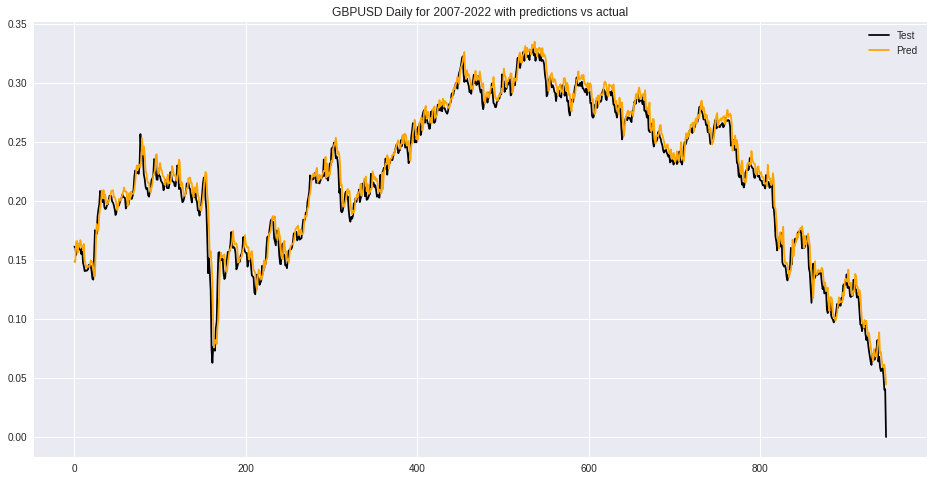

In [ ]:
# Plotting the predicted versus actual data values.
plt.figure(figsize=(16,8))
plt.plot( y_test, color = 'black', label = 'Test' )
plt.plot( y_pred, color = 'orange', label= 'Pred' )
plt.legend()
plt.title("GBPUSD Daily for 2007-2022 with predictions vs actual")
plt.show()